In [5]:
import time
import numpy as np
from keras.datasets import cifar10
from keras.datasets import mnist
import matplotlib.pyplot as plt
#using tensorflow backend

Using TensorFlow backend.


In [6]:
#ok, verificado
#me pone el bias de manera correcta
#con el 1 al final
def reshapeimages(x,y):
    im_shape = x.shape[1:]
    x = np.reshape(x,(x.shape[0],np.prod(im_shape)))
    a = np.zeros((x.shape[0],np.prod(im_shape)+1))+1
    a[:,:-1] = x #le agrego los 1 al final de fila
    return a,y

In [7]:
#sampleo de data para los batch
def createbatch(x,y,batchsize):
    indices = np.random.choice(x.shape[0], batchsize, replace=False) #toma batchsize de filas random
    x_batch = x[indices] #selecciono en x y obtengo el batch
    y_batch = y[indices] #selecciono en y obtengo el batch
    return x_batch,y_batch

In [8]:
class LinearClassifier:
    #constructor, solo digo que tengo W
    def __init__(self):
        self.W = None
    #inicializo la matriz de pesos randomly
    def randominicializar(self,k,d):
        self.W = np.random.rand(d,k) #en un rango [0,1) 
        self.W = self.W/1000 #elementos chicos  
    #paso una imagenes y me da el score para cada una
    def predict(self,x):
        yp = np.zeros(x.shape[0],np.uint8)
        for i in range(x.shape[0]):
            s = (x[i,:]).dot(self.W)
            idx = np.argmax(s)
            yp[i] = idx
        return yp
    #funcion de la practica, definida despues para cada linear classifier
    def loss_gradient(self,x,y):
        pass
    #funcion de costo, idem comentario que la anterior
    def loss_fun(self,x,y):
        pass
    
    #funcion accuracy
    def accuracy(self,x,y):
        ypr = self.predict(x)
        accpercent =  np.mean(ypr==y)*100 #lo devuelve en porcentaje
        return accpercent 
        
    #fit igual para SVM y softmax, como hablamos el miercoles con las epocas
    def fit(self,x,y,batchsize,alpha):
        epocas = 20
        vloss = []
        vacc = []
        for i in range(epocas):
            x,y = createbatch(x,y,x.shape[0])
            nit = (x.shape[0]/batchsize)
            it = 0
            index = 0
            vloss.append(self.loss_fun(x_test,y_test))
            vacc.append(self.accuracy(x_test,y_test))
            print("nit: ",nit)
            while it < nit:
                x_batch = x[index:index+batchsize]
                y_batch = y[index:index+batchsize]
                index = index + batchsize
                loss,grad = self.loss_gradient(x_batch,y_batch)
                self.W = self.W - (alpha)*(grad)
                it = it + 1
        return vloss,vacc
        

In [2]:
class SVM(LinearClassifier):
    #data loss para una imagen en particular
    def __init__(self,lam,delta=1):
        super().__init__() #herencia
        self.delta = delta
        self.lam = lam
    #calculo la loss y el gradiente
    #(nota personal: version modificada, la anterior del gradiente andaba lenta por el for)
    #(no confundirme con la notebook ejercicio5)
    def loss_gradient(self,x,y):
        #calculo la loss
        s = x.dot(self.W)
        y = list(y)
        sy = s[np.arange(x.shape[0]), y]
        margen = s-sy[:,np.newaxis]+self.delta
        margen = np.maximum(0,margen)
        margen[np.arange(x.shape[0]),y] = 0       
        loss = margen.sum(axis=1)
        loss = np.mean(loss)
        W2 = (self.W*self.W).flatten()
        loss = loss + (self.lam)*(sum(W2))
        #calculo el gradiente
        binary = margen.copy()
        binary[binary>0]=1
        #clases que no dan ok, donde va la suma de las que le ganan a la correcta
        aux = binary.sum(axis=1)
        binary[np.arange(x.shape[0]),y] = -aux
        grad = (x.T).dot(binary) #como estaba en las slides
        grad = grad/(x.shape[0])
        grad = grad + 2*(self.W)*(self.lam)
        return loss,grad
    #defino la loss function para SVM
    def loss_fun(self,x,y):
        s = x.dot(self.W)
        y = list(y)
        sy = s[np.arange(x.shape[0]), y]
        margen = s-sy[:,np.newaxis]+self.delta 
        #nota personal: no quitar el newaxis, no estoy haciendo reshape como en la version anterior
        margen = np.maximum(0,margen)
        margen[np.arange(x.shape[0]),y] = 0       
        loss = margen.sum(axis=1)
        loss = np.mean(loss)
        W2 = (self.W*self.W).flatten()
        loss = loss + (self.lam)*(sum(W2))
        return loss
                

In [3]:
class SoftMax(LinearClassifier):
    def __init__(self,lam):
        super().__init__() #herencia
        self.lam = lam
    #defino loss gradient para SoftMax
    def loss_gradient(self,x,y):
        #primero calculamos el data loss
        s = x.dot(self.W)
        sm = s.max(axis=1)
        #teniendo en cuenta la estabilidad numerica
        s = s - sm[:,np.newaxis] #ref:notas de stanford cs231n, se hace esto para estabilidad numerica
        sy = s[np.arange(x.shape[0]),y]
        s = np.exp(s)
        aux = s.sum(axis=1)
        loss = np.log(aux) - sy
        loss = loss.mean()
        W2 = (self.W*self.W).flatten()
        loss = loss + (self.lam)*(sum(W2))
        #calculo gradiente 
        grad = (1/aux)[:,np.newaxis]*s
        grad[np.arange(y.shape[0]),y] = grad[np.arange(y.shape[0]),y] - 1
        grad = ((x.T).dot(grad))/(x.shape[0])
        W2 = (self.W*self.W).flatten()
        grad = grad + (self.lam)*(sum(W2))
        return loss,grad
    #defino loss function para SoftMax
    def loss_fun(self,x,y):
        #primero calculamos el data loss
        s = x.dot(self.W)
        sm = s.max(axis=1)
        #teniendo en cuenta la estabilidad numerica
        s = s - sm[:,np.newaxis] #ref:notas de stanford cs231n, se hace esto para estabilidad numerica
        sy = s[np.arange(x.shape[0]),y]
        exp = np.exp(s)
        aux = exp.sum(axis=1)
        loss = np.log(aux) - sy
        loss = loss.mean()
        W2 = (self.W*self.W).flatten()
        loss = loss + (self.lam)*(sum(W2))
        return loss

# MNIST 20 EPOCHS 10 DATA BATCH + PREDICTION SVM

In [4]:
(x_train,y_train),(x_test,y_test) = mnist.load_data() #x = images #y = categories #loading data
x_train = x_train
y_train = y_train
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)
x_test = x_test
y_test = y_test

NameError: name 'mnist' is not defined

In [28]:
k=10 #10 categories
d=x_train.shape[1]
delta = 1 # delta del SVM
lam = 1e-3 #lambda de la reg
alpha = 1e-6 #alpha del step
s = SVM(lam,delta)
s.randominicializar(k,d)
vloss, vacc = s.fit(x_train,y_train,10,alpha)

nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0


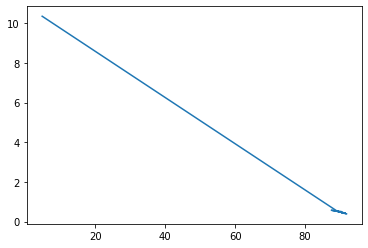

In [33]:
plt.scatter(vacc,vloss)

In [34]:
ytestpr =  s.predict(x_test)
y_test = y_test.flatten()
print(ytestpr.shape)
print(y_test.shape)
print(np.mean(ytestpr==y_test)*100) #lo devuelve en porcentaje

(10000,)
(10000,)
91.07


#  MNIST 20 EPOCHS 10 DATA BATCH + PREDICTION  SOFTMAX

In [ ]:
(x_train,y_train),(x_test,y_test) = mnist.load_data() #x = images #y = categories #loading data
x_train = x_train
y_train = y_train
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)
x_test = x_test
y_test = y_test

In [37]:
k=10 #10 categories
d=x_train.shape[1]
delta = 1 # delta del SVM
lam = 1e-3 #lambda de la reg
alpha = 1e-6 #alpha del step
s = SoftMax(lam)
s.randominicializar(k,d)
vloss, vacc = s.fit(x_train,y_train,10,alpha)

nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0
nit:  6000.0


In [38]:
ytestpr =  s.predict(x_test)
y_test = y_test.flatten()
print(ytestpr.shape)
print(y_test.shape)
print(np.mean(ytestpr==y_test)*100) #lo devuelve en porcentaje

(10000,)
(10000,)
92.16


[16.215,
 91.26333333333334,
 91.50833333333334,
 92.19833333333334,
 92.425,
 92.435,
 92.52,
 92.525,
 92.69166666666668,
 92.75,
 92.47833333333332,
 92.80333333333334,
 92.86999999999999,
 93.03333333333333,
 92.85333333333334,
 92.97333333333333,
 92.85833333333333,
 93.15166666666667,
 92.89666666666668,
 93.10666666666667]

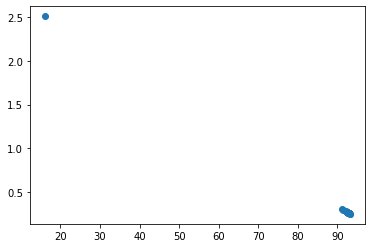

In [41]:
plt.scatter(vacc,vloss)
vacc

# CIFAR10 10 DATA BATCH + PREDICTION SVM

In [42]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
y_test = y_test.flatten()
y_train = y_train.flatten()

In [43]:
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)

In [44]:
k=10 #10 categories
d=x_train.shape[1]
delta = 1 # delta del SVM
lam = 1e-3 #lambda de la reg
alpha = 1e-6 #alpha del step
s = SoftMax(lam)
s.randominicializar(k,d)
vloss, vacc = s.fit(x_train,y_train,10,alpha)

nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0


In [45]:
ytestpr =  s.predict(x_test)
y_test = y_test.flatten()
print(ytestpr.shape)
print(y_test.shape)
print(np.mean(ytestpr==y_test)*100) #lo devuelve en porcentaje

(10000,)
(10000,)
30.89


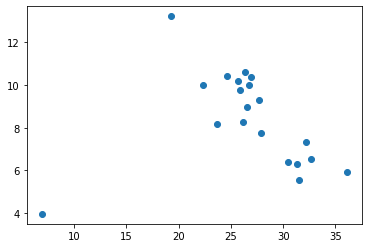

In [46]:
plt.scatter(vacc,vloss)

# CIFAR10 10 DATA BATCH + PREDICTION Softmax

In [7]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data() #x = images #y = categories #loading data
y_test = y_test.flatten()
y_train = y_train.flatten()

In [8]:
x_train,y_train = reshapeimages(x_train,y_train)
x_test,y_test = reshapeimages(x_test,y_test)

In [9]:
k=10 #10 categories
d=x_train.shape[1]
delta = 1 # delta del SVM
lam = 1e-3 #lambda de la reg
alpha = 1e-6 #alpha del step
s = SoftMax(lam)
s.randominicializar(k,d)
vloss, vacc = s.fit(x_train,y_train,10,alpha)

nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0
nit:  5000.0


In [10]:
ytestpr =  s.predict(x_test)
y_test = y_test.flatten()
print(ytestpr.shape)
print(y_test.shape)
print(np.mean(ytestpr==y_test)*100) #lo devuelve en porcentaje

(10000,)
(10000,)
24.69


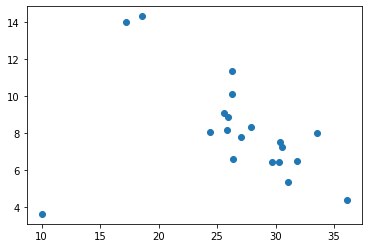

In [11]:
plt.scatter(vacc,vloss)